In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

* DONE: clean-up, simplify thalamocort_params
* DONE: simtime_show
* DONE: circulant matrix? no, Toeplitz is very fine.
* DONE: add noise
* DONE: response as a function of B_input
* DONE: response as a function of noise

# generating a synthetic input


In [2]:
import numpy as np

In [3]:
import pyNN.nest as sim
#from pyNN.random import RandomDistribution, NumpyRNG

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/usr/local/lib/python3.7/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [4]:
# === Define parameters ========================================================
dt         = 0.5           # (ms)
simtime    = 20000.0        # (ms)
#simtime    = 3000.0        # (ms)
simtime_show = 1000.0      # (ms)

N_inputs = 60
tau = 50.
t_start = 100.
N_starts = simtime // (tau)

t_starts = np.linspace(t_start, simtime-tau-t_start, int(N_starts))

N_scan = 9

lambda_n = 2.5 # (Hz) rate of poisson noise
theta = .50
B_true = .61803

In [5]:
def vonmises(N_inputs, theta=theta, B=B_true):
    return np.exp((np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))-1)/B**2)

def get_latency(spike_times, current, tau=50., t_start=100.):
    N_inputs = current.size
    if spike_times is None:
        spike_times = []
        for i_input in range(N_inputs):
            spike_times.append([])
            
    for i_input in range(N_inputs):
        if current[i_input] > 1:
            spike_time = t_start + tau * np.log(1/(1 - 1/current[i_input]))
            spike_times[i_input].append(spike_time)
            
    return spike_times

def celebrini(N_inputs, A=2.2, theta=theta, B=B_true, tau=50., t_start=t_starts, verbose=False):
    # https://www.cambridge.org/core/journals/visual-neuroscience/article/dynamics-of-orientation-coding-in-area-v1-of-the-awake-primate/906FA662AD71B432EB6D4F10795A397A
    
    current = A * vonmises(N_inputs, theta=theta, B=B)
    if verbose : print('current.max()', current.max())

    spike_times = None
    for t_start_ in t_start:
        spike_times = get_latency(spike_times, current, tau=tau, t_start=t_start_)
    if verbose : print('spike_times', spike_times)
    #spike_source = sim.Population(N_inputs, sim.SpikeSourceArray(spike_times=spike_times))
    spike_source = sim.SpikeSourceArray(spike_times=spike_times)
    
    return spike_source

spike_source = celebrini(N_inputs, verbose=False)

In [6]:
import matplotlib.pyplot as plt

def plot_spiketrains(spiketrains, simtime=None, simtime_show=None, fig=None, ax=None, 
                     color='r', markersize=4, verbose=False):
    """
    Plot all spike trains in a Segment in a raster plot.
    
    marker size is in points.
    
    """
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    
    if simtime is None:
        from quantities import ms
        simtime = spiketrains[0].t_stop / ms
    if simtime_show is None:
        simtime_show = simtime

    if verbose: print('spiketrains[0].t_stop', spiketrains[0].t_stop)
    from sys import maxsize
    max_index = 0
    min_index = maxsize
    for spiketrain in spiketrains:
        ax.plot(spiketrain,
                 np.ones_like(spiketrain) * spiketrain.annotations['source_index'],
                 '|', c=color, markersize=markersize)
        max_index = max(max_index, spiketrain.annotations['source_index'])
        min_index = min(min_index, spiketrain.annotations['source_index'])
    ax.set_ylabel("Neuron index")
    ax.set_xlabel('Time(ms)')
    # print('simtime_show', simtime_show)
    ax.set_xlim(0, simtime_show)
    ax.set_ylim(-0.5 + min_index, max_index + 0.5)
    return fig, ax


In [7]:
def spike_count_per_neuron(pop):
    sc = pop.get_spike_counts()
    return np.array([sc[i] for i in pop.all_cells])

def color(i=0, sat=1):
    c = [0, 0, 0]
    c[i] = sat 
    return c


def histogram(output, fig=None, ax=None, sat=1, lw=1, label='tc_cells'):
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    ax.plot(spike_count_per_neuron(output['noise'])/output['simtime']*1000., color=color(0, sat), lw=lw)
    ax.plot(spike_count_per_neuron(output['spike_input'])/output['simtime']*1000., color=color(1, sat), lw=lw)
    ax.plot(spike_count_per_neuron(output['tc_cells'])/output['simtime']*1000., color=color(2, sat), lw=lw, label=label)
    return fig, ax


# feeding that input to a range of orientation selective cells

In [8]:
sim.IF_cond_alpha.get_parameter_names()

['v_rest',
 'cm',
 'tau_m',
 'tau_refrac',
 'tau_syn_E',
 'tau_syn_I',
 'e_rev_E',
 'e_rev_I',
 'v_thresh',
 'v_reset',
 'i_offset']

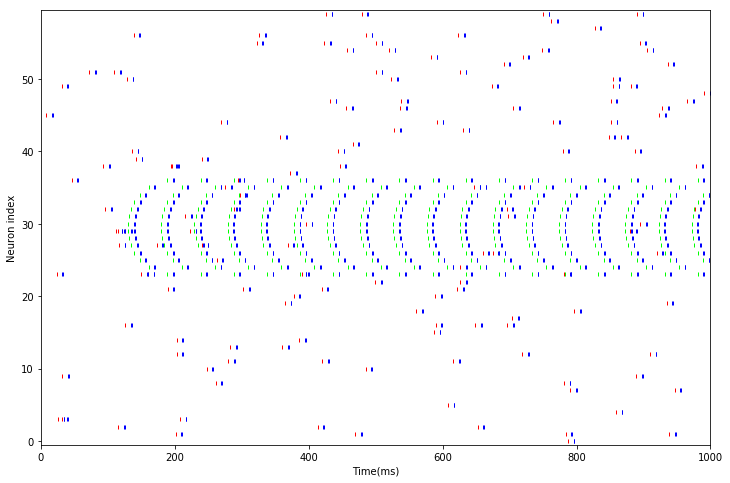

In [9]:

def LSD_neuron(weights, delays, dt=dt, simtime=simtime, simtime_show=simtime_show, t_starts=t_starts, 
               do_complex=False, lambda_n=lambda_n, B_true=B_true, fig=None, ax=None, sat=1, verbose=False):

    # === Build the network ========================================================
    sim.setup(timestep=dt)
    # N_inputs, A=2.2, tau=50., theta=.50, B=.61803, t_start=100., verbose=False
    spike_source = celebrini(N_inputs, B=B_true, t_start=t_starts, verbose=False)
    spike_input = sim.Population(N_inputs, spike_source)
    spike_input.record('spikes')
    
    noise = sim.Population(N_inputs, sim.SpikeSourcePoisson(rate=lambda_n, duration=simtime), label="expoisson")        
    noise.record('spikes')
        
    if do_complex:
        #With PyNN, the model is defined by CellType classes, whose models work on any simulator
        refraction_time = RandomDistribution('uniform', [2.0, 3.0], rng = NumpyRNG(seed = 1234))
        thalamocort_params = {'cm':0.25, 'tau_m':20.0, 'v_rest':-60, 'v_thresh':-50, 'tau_refrac':refraction_time, 
                           'v_reset':-60,
                          'v_spike':-50.0, 'a':1.0, 'b':0.005, 'tau_w':600, 'delta_T':2.5, 'tau_syn_E':5.0, 'e_rev_E':0.0,
                          'tau_syn_I':10.0, 'e_rev_I':-80}
        #thalamocort_params.update({'a':20, 'b': 0.0})

        thalamocort_cell = sim.EIF_cond_exp_isfa_ista(**thalamocort_params)
    else:
        #thalamocort_cell = sim.Izhikevich(i_offset=0.01)
        thalamocort_cell = sim.IF_cond_alpha()
        
        
    tc_cells = sim.Population(N_inputs, thalamocort_cell)
    tc_cells.record('spikes')

    #Synapses type
    delayed_synapses = sim.StaticSynapse()
    #connectivity using the projection method
    connections = sim.Projection(spike_input, tc_cells,
                                        connector=sim.AllToAllConnector(),
                                        synapse_type=delayed_synapses,
                                        receptor_type='excitatory',
                                        label="excitatory connections")

    connections.set(weight = weights, delay = delays)

    connections_noise = sim.Projection(noise, tc_cells,
                                        connector=sim.AllToAllConnector(),
                                        synapse_type=delayed_synapses,
                                        receptor_type='excitatory',
                                        label="excitatory connections")
    
    connections_noise.set(weight = weights, delay = delays)

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    #sim.reset()
    
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    sts_noise = noise.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_noise, color=color(0, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax)
    
    sts_in = spike_input.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(sts_in, color=color(1, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax)
    if verbose: print('sts_in', [list(st.as_array()) for st in sts_in])
    
    sts_out = tc_cells.get_data().segments[0].spiketrains
    if verbose: print('sts_out', [list(st.as_array()) for st in sts_out])
    fig, ax = plot_spiketrains(sts_out, color=color(2, sat), simtime=simtime, simtime_show=simtime_show, fig=fig, ax=ax)
    
    #output = dict(noise=noise, spike_input=spike_input, tc_cells=tc_cells)
    #output.update(locals())
    return fig, ax, locals()

weight_0, delay_0 = 4, 8.2
weights = weight_0 * np.diag(np.ones(N_inputs))
delays = delay_0 * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
fig, ax, output = LSD_neuron(weights, delays)
    

# Testing different base weights:

weight_0_ 0.6666666666666666
weight_0_ 1.0433897200488582
weight_0_ 1.632993161855452
weight_0_ 2.5557724169850897
weight_0_ 4.0
weight_0_ 6.260338320293149
weight_0_ 9.797958971132712
weight_0_ 15.33463450191054
weight_0_ 24.0


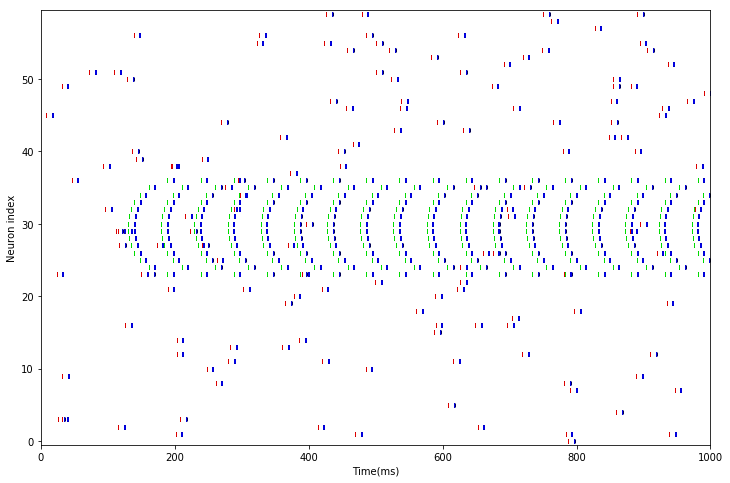

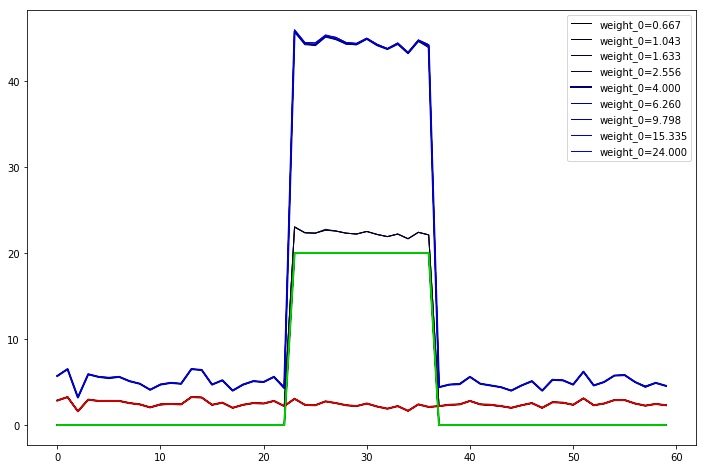

In [10]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6, endpoint=True)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    weights = weight_0_ * np.diag(np.ones(N_inputs))
    delays = delay_0 * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

delay_0_ 4.1
delay_0_ 4.875749171511155
delay_0_ 5.79827560572969
delay_0_ 6.895350605080458
delay_0_ 8.2
delay_0_ 9.75149834302231
delay_0_ 11.59655121145938
delay_0_ 13.790701210160917
delay_0_ 16.4


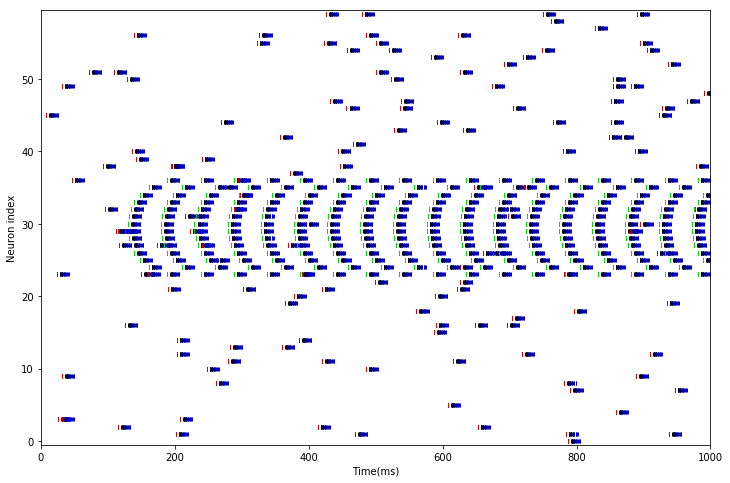

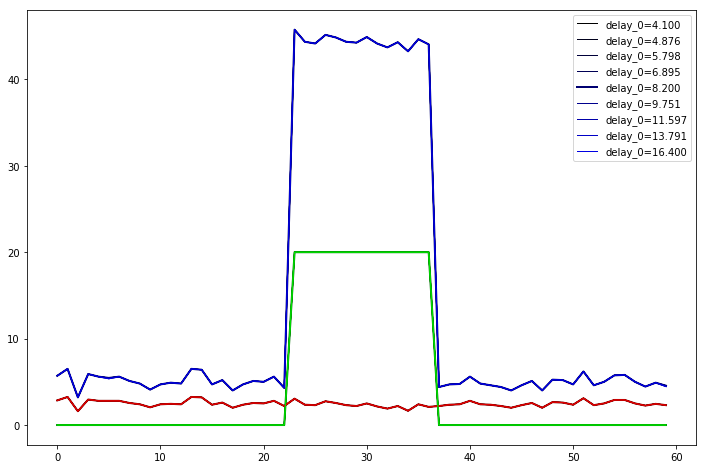

In [11]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, delay_0_ in enumerate(delay_0*np.logspace(-1, 1, N_scan, base=2)):
    print('delay_0_', delay_0_)
    label = 'delay_0=%.3f' % delay_0_
    weights = weight_0 * np.diag(np.ones(N_inputs))
    delays = delay_0_ * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');      

delay_0_ 40
delay_0_ 140


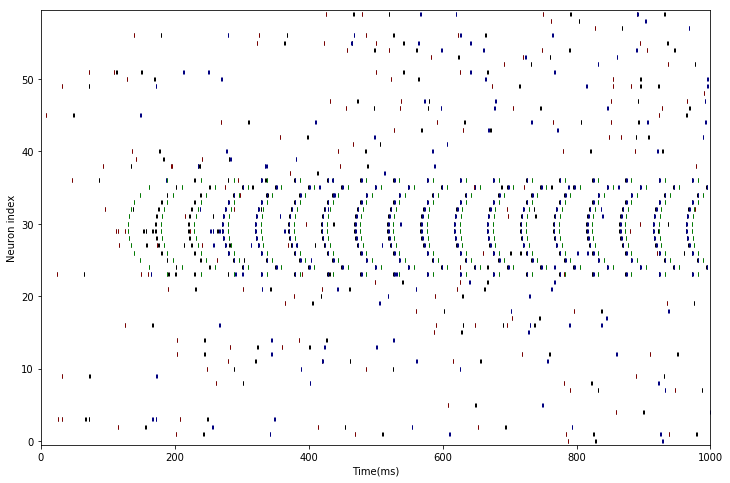

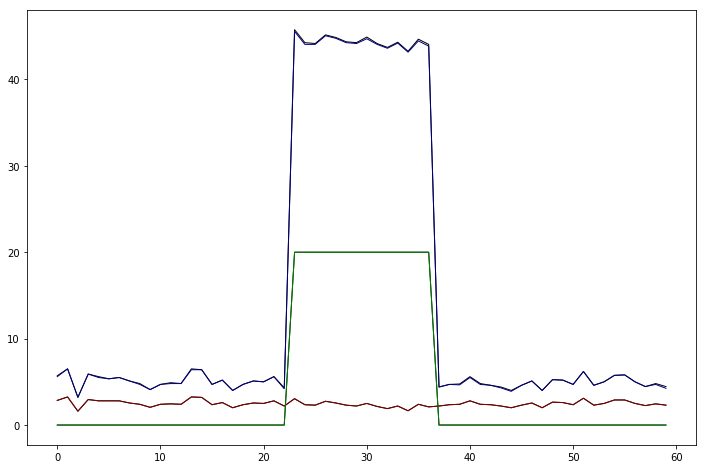

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, delay_0_ in enumerate([40, 80]):
    print('delay_0_', delay_0_)
    weights = weight_0 * np.diag(np.ones(N_inputs))
    delays = delay_0_ * np.ones((N_inputs, N_inputs)) #np.diag(np.ones(N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/2)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/2)    


DONE: undestood why the whole input raster also moves = one has to set weights to the projection object not to the synapses

# Testing different tuning curves on the weights

using https://fr.wikipedia.org/wiki/Matrice_de_Toeplitz 

In [13]:
weight_0 = .4


In [14]:
from scipy.linalg import toeplitz


weight_0_ 0.06666666666666667
weight_0_ 0.10433897200488583
weight_0_ 0.16329931618554522
weight_0_ 0.255577241698509
weight_0_ 0.4
weight_0_ 0.626033832029315
weight_0_ 0.9797958971132712
weight_0_ 1.533463450191054
weight_0_ 2.4000000000000004


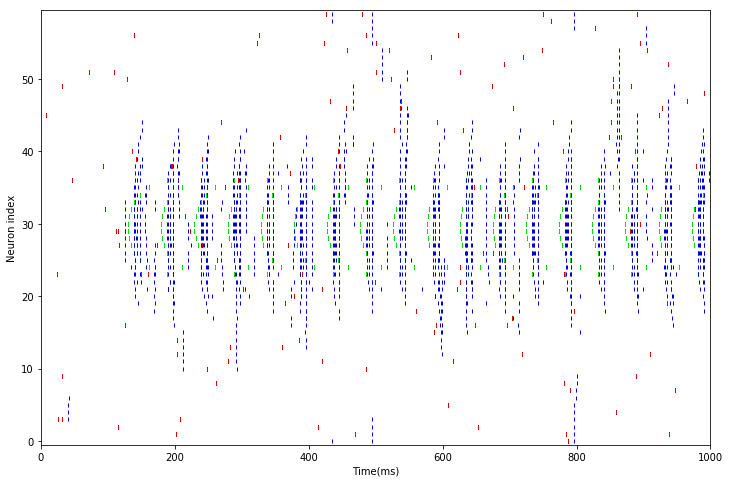

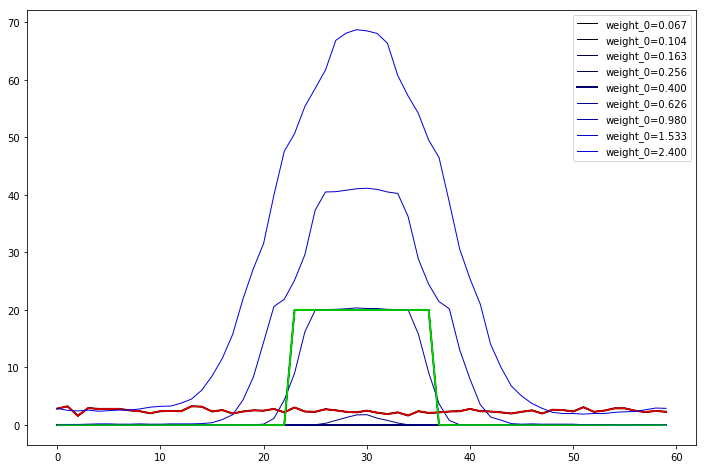

In [15]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))

for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    tf = vonmises(N_inputs, theta=.0)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');   

B_ 0.1545075
B_ 0.218506601988361
B_ 0.309015
B_ 0.437013203976722
B_ 0.61803
B_ 0.874026407953444
B_ 1.23606
B_ 1.748052815906888
B_ 2.47212


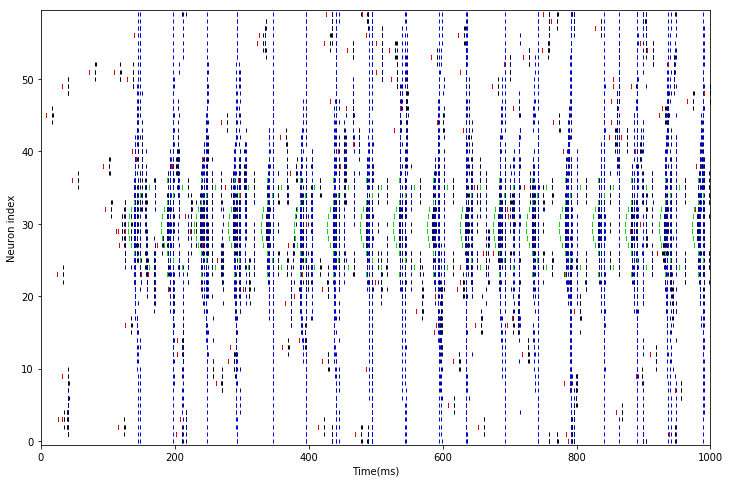

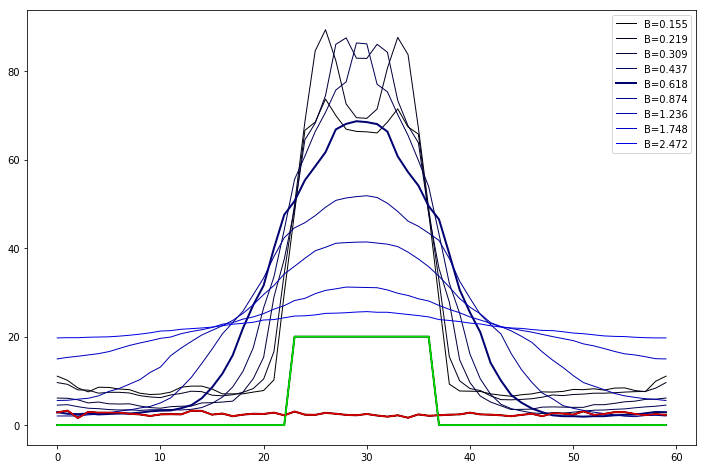

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, B_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=4)):
    print('B_', B_)
    label = 'B=%.3f' % B_    
    tf = vonmises(N_inputs, theta=.0, B=B_)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

B_true_ 0.1545075
B_true_ 0.218506601988361
B_true_ 0.309015
B_true_ 0.437013203976722
B_true_ 0.61803
B_true_ 0.874026407953444
B_true_ 1.23606
B_true_ 1.748052815906888
B_true_ 2.47212


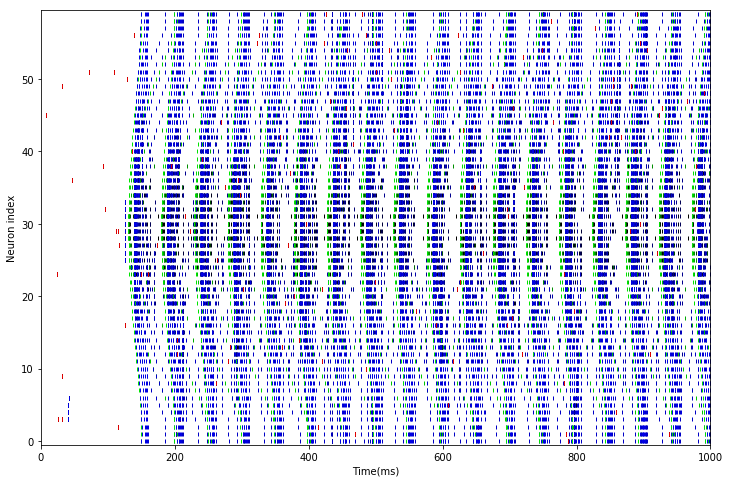

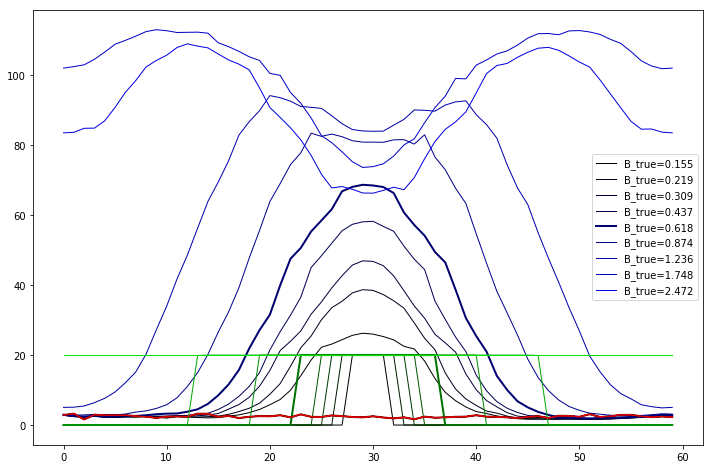

In [17]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, B_true_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=4)):
    print('B_true_', B_true_)
    label = 'B_true=%.3f' % B_true_    
    tf = vonmises(N_inputs, theta=.0, B=B_true)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0 * np.ones((N_inputs, N_inputs))
    
    fig, ax, output = LSD_neuron(weights, delays, B_true=B_true_, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

# Testing different tuning curves on the weights and delays

Some heuristics:

weight_0_ 0.06666666666666667
weight_0_ 0.10433897200488583
weight_0_ 0.16329931618554522
weight_0_ 0.255577241698509
weight_0_ 0.4
weight_0_ 0.626033832029315
weight_0_ 0.9797958971132712
weight_0_ 1.533463450191054
weight_0_ 2.4000000000000004


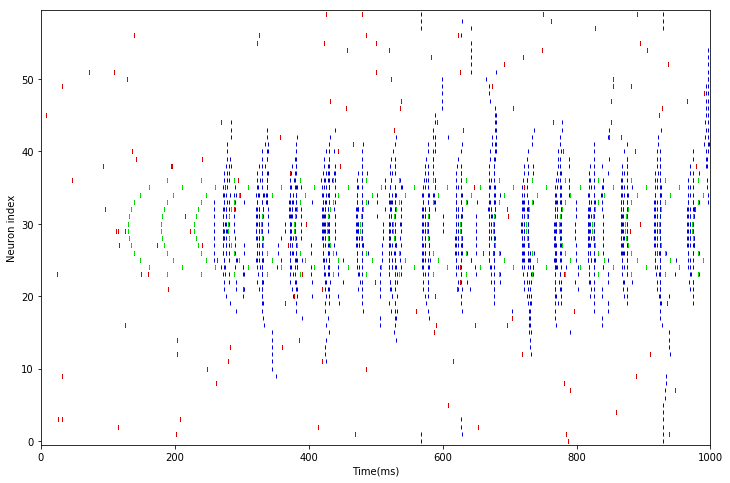

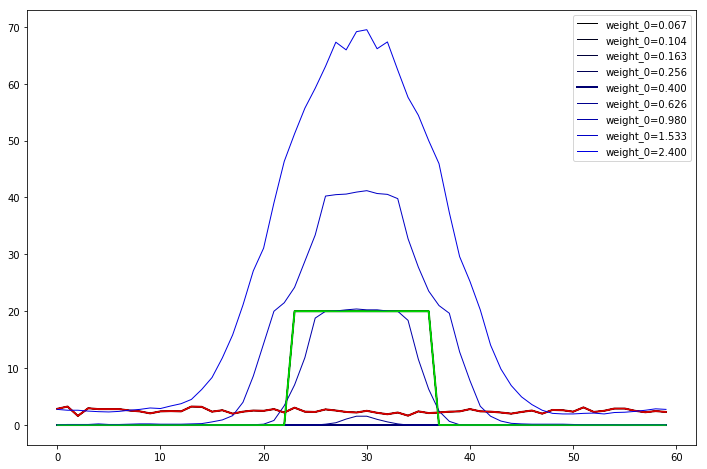

In [18]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_
    tf = vonmises(N_inputs, theta=.0, B=B_true)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)
    delays = delay_0_ * (1 + toeplitz(vonmises(N_inputs)))
    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

In [24]:

A_est = 2.3
B_est = 0.61803
tau_est = tau 

current = A_est * vonmises(N_inputs, theta=0., B=B_est)
print('current.max()', current.max())
spike_times = np.array(get_latency(None, current, tau=tau_est, t_start=0.))
print('spike_times.max()', np.max(spike_times))

current.max() 2.3
spike_times.max() [102.25673755312592]


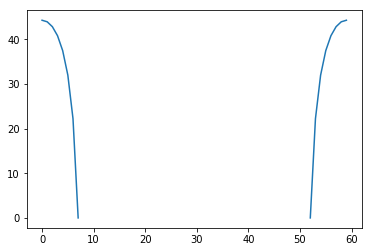

In [25]:
def get_delay_line(N_inputs, A_est = 2.3, B_est = 0.61803, tau_est = 30 ):
    current = A_est * vonmises(N_inputs, theta=0., B=B_est)
    spike_times = get_latency(None, current, tau=tau_est, t_start=0.)
    
    spike_times_, mask = np.zeros(N_inputs), np.ones(N_inputs)
    for i in range(N_inputs):
        if len(spike_times[i]) > 0: 
            spike_times_[i] = spike_times[i][0]
        else:
            spike_times_[i] = np.nan
    
    tau_max = np.nanmax(spike_times_)
    delay_line = tau_max - spike_times_
    return delay_line
plt.plot(get_delay_line(N_inputs))

weight_0_ 0.06666666666666667
weight_0_ 0.10433897200488583
weight_0_ 0.16329931618554522
weight_0_ 0.255577241698509
weight_0_ 0.4
weight_0_ 0.626033832029315
weight_0_ 0.9797958971132712
weight_0_ 1.533463450191054
weight_0_ 2.4000000000000004


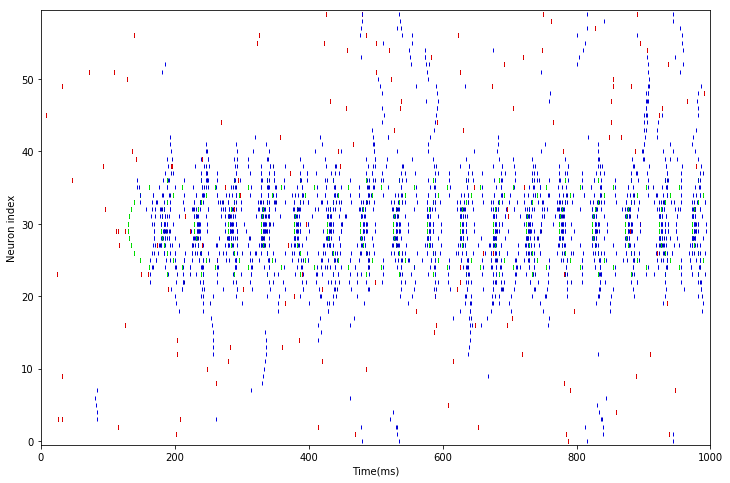

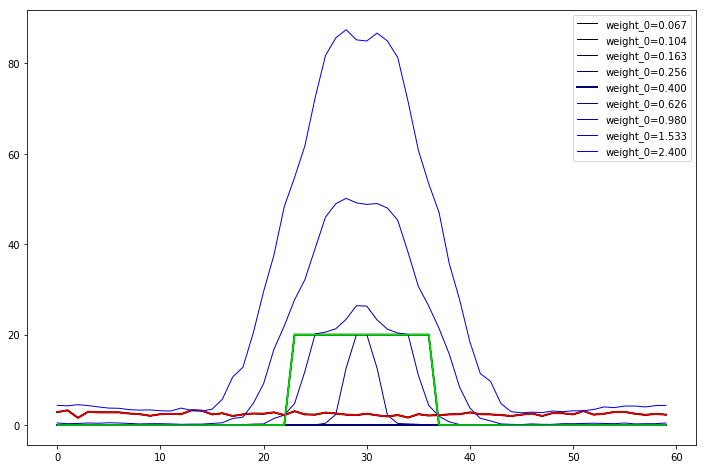

In [26]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))

#weight_0 = .4

for i_scan, weight_0_ in enumerate(weight_0*np.logspace(-1, 1, N_scan, base=6)):
    print('weight_0_', weight_0_)
    label = 'weight_0=%.3f' % weight_0_

    delay_line = get_delay_line(N_inputs)
    
    delays = delay_0 + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B_est)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)

    fig, ax, output = LSD_neuron(weights, delays, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

B_true_ 0.1545075
B_true_ 0.218506601988361
B_true_ 0.309015
B_true_ 0.437013203976722
B_true_ 0.61803
B_true_ 0.874026407953444
B_true_ 1.23606
B_true_ 1.748052815906888
B_true_ 2.47212


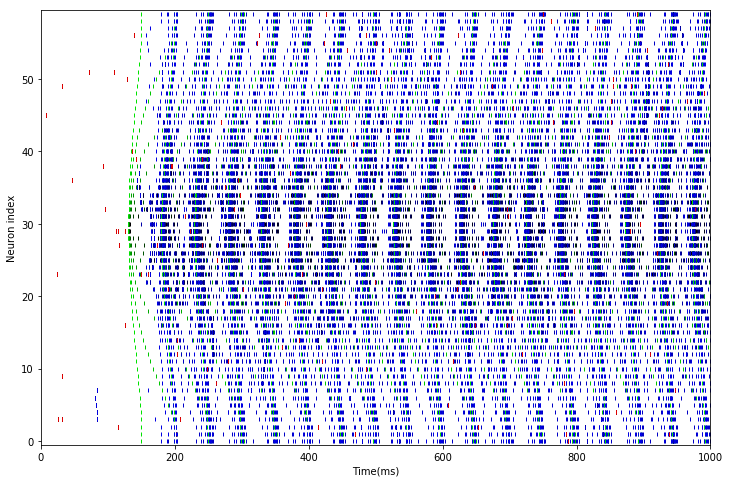

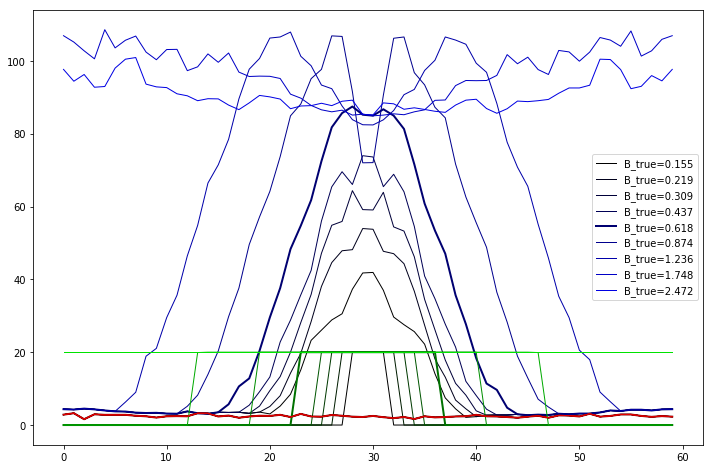

In [22]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))
for i_scan, B_true_ in enumerate(B_true*np.logspace(-1, 1, N_scan, base=4)):
    print('B_true_', B_true_)
    label = 'B_true=%.3f' % B_true_    

    delay_line = get_delay_line(N_inputs, B_est=B_true)
    delays = delay_0 + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B_est)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)    
    
    fig, ax, output = LSD_neuron(weights, delays, B_true=B_true_, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    

As a  function  of noise lambda_n :

lambda_n 0.25
lambda_n 0.44456985250973075
lambda_n 0.7905694150420949
lambda_n 1.4058533129758728
lambda_n 2.5
lambda_n 4.445698525097307
lambda_n 7.905694150420949
lambda_n 14.058533129758729
lambda_n 25.0


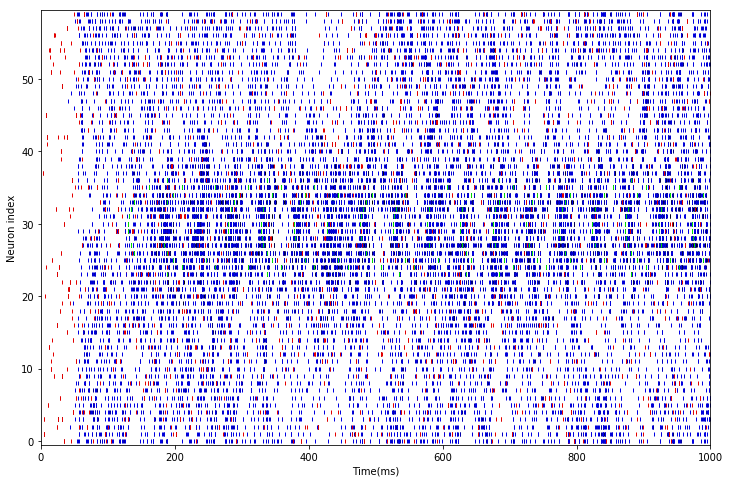

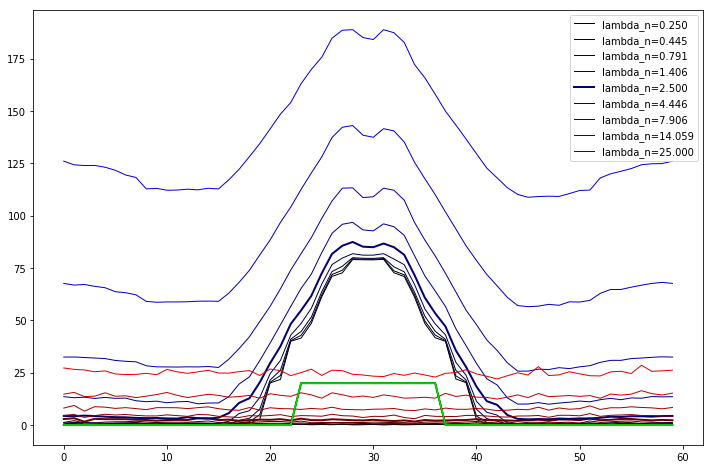

In [23]:
fig, ax = plt.subplots(figsize = (12,8))
hfig, hax = plt.subplots(figsize = (12,8))

for i_scan, lambda_n_ in enumerate(lambda_n*np.logspace(-1, 1, N_scan, base=10)):
    print('lambda_n', lambda_n_)
    label = 'lambda_n=%.3f' % lambda_n_

    delay_line = get_delay_line(N_inputs, B_est=B_est)
    delays = delay_0 + toeplitz(np.where(np.isnan(delay_line), 0, delay_line))

    tf = vonmises(N_inputs, theta=.0, B=B_est)
    tf = np.where(np.isnan(delay_line), 0, tf)
    tf /= tf.sum()
    weights = weight_0_ * toeplitz(tf)

    fig, ax, output = LSD_neuron(weights, delays, lambda_n=lambda_n_, fig=fig, ax=ax, sat=i_scan/N_scan)
    hfig, hax = histogram(output, fig=hfig, ax=hax, sat=i_scan/N_scan, label=label, lw=2 if i_scan==N_scan//2 else 1)    
hax.legend(loc='best');    